**箱线图**

箱线图共五条线，分别为：上边缘、上四分位数、中位数、下四分位数、下边缘。

<AxesSubplot:>

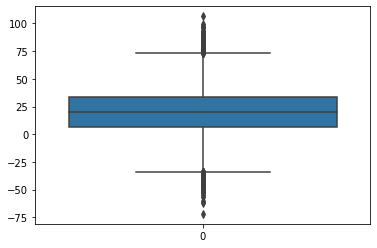

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = np.random.randn(50000) * 20 + 20
sns.boxplot(data=data)

In [2]:
np.random.randn(5)

array([-0.26011501,  0.14906896,  0.08078486, -0.4116773 ,  0.24696797])

## HBOS算法实践

In [3]:
import numpy as np
import pandas as pd
import pyod
from sklearn.model_selection import train_test_split

In [4]:
# 打印cell中的多个输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# 数据源来自kaggle的信用卡欺诈数据 https://www.kaggle.com/mlg-ulb/creditcardfraud
data = pd.read_csv(r"D:\WorkSpace\GitHub\DataWhale_LearningNote\AnomalyDetection\creditcard.csv")

In [6]:
data.head(5)
# data.info()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
X = data.iloc[:,data.columns != "Class"]
y = data.iloc[:,data.columns == "Class"]
X.shape
y.shape
# 查看分类标签及分布
y.value_counts()

(284807, 30)

(284807, 1)

Class
0        284315
1           492
dtype: int64

In [8]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3)

In [9]:
from pyod.models.hbos import HBOS
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.iforest import IForest

**HBOS模型参数**

contamination 异常数据占比 (default=0.1)

n_bins 分箱数(default=10)

alpha 防止溢出的正则化项(default=0.1)  *没懂*

tol 当样本落在箱外时，决定其灵活性的参数(default=0.5)  *没懂*

### 一点记录

**1. contamination默认为0.1，模型效果**
```
On Training Data:
HBOS ROC:0.952, precision @ rank n:0.4153

On Test Data:
HBOS ROC:0.9497, precision @ rank n:0.3333

precision_score(Ytrain, y_train_pred, average='binary') 
0.015799769273210612

```

**2. contamination调整为实际比例0.0017时 ，模型效果：**


```
On Training Data:
HBOS ROC:0.9582, precision @ rank n:0.2941

On Test Data:
HBOS ROC:0.9397, precision @ rank n:0.3407

precision_score(Ytrain, y_train_pred, average='binary') 
0.3008849557522124
```

**3. 每次运行结果都不一样，有时还差挺多，模型不够稳定？**

In [10]:
clf_name="HBOS"
# clf=HBOS()
clf = HBOS(contamination=0.0017,n_bins=20)
# clf_name="IForest"
# clf = IForest(contamination=0.0017)
clf.fit(Xtrain)

HBOS(alpha=0.1, contamination=0.0017, n_bins=20, tol=0.5)

In [11]:
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
[*[y_train_pred]]
y_train_pred.shape
[*[y_train_scores]]
y_train_scores.shape

[array([0, 0, 0, ..., 0, 0, 0])]

(199364,)

[array([47.00789897, 44.5408832 , 48.24446886, ..., 49.47454355,
        49.18075504, 55.0022202 ])]

(199364,)

In [12]:
y_test_pred = clf.predict(Xtest)
y_test_scores = clf.decision_function(Xtest)

In [13]:
y_test_pred
y_test_scores

array([0, 0, 0, ..., 0, 0, 0])

array([50.71910889, 48.00780335, 47.32718412, ..., 48.24957588,
       50.8184037 , 46.53969631])

In [14]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, Ytrain, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, Ytest, y_test_scores)


On Training Data:
HBOS ROC:0.9551, precision @ rank n:0.2803

On Test Data:
HBOS ROC:0.9465, precision @ rank n:0.2877


In [15]:
from sklearn.metrics import precision_score
precision_score(Ytrain, y_train_pred, average='binary') 
# precision_score(Ytest, y_test_pred, average='macro')
# precision_score(Ytest, y_test_pred, average='binary')

0.2831858407079646

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Ytest, y_test_pred)

array([[85200,    97],
       [  106,    40]], dtype=int64)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(Ytrain, y_train_pred))
print(classification_report(Ytest, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199018
           1       0.28      0.28      0.28       346

    accuracy                           1.00    199364
   macro avg       0.64      0.64      0.64    199364
weighted avg       1.00      1.00      1.00    199364

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.29      0.27      0.28       146

    accuracy                           1.00     85443
   macro avg       0.65      0.64      0.64     85443
weighted avg       1.00      1.00      1.00     85443



In [18]:
data[data['Class']==1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [19]:
print(y_train_pred.sum())
print(y_test_pred.sum())

339
137


**模型属性**

    bin_edges_ : numpy array of shape (n_bins + 1, n_features )
        The edges of the bins.

    hist_ : numpy array of shape (n_bins, n_features)
        The density of each histogram.

    decision_scores_ : numpy array of shape (n_samples,)
        The outlier scores of the training data.
        The higher, the more abnormal. Outliers tend to have higher
        scores. This value is available once the detector is fitted.

    threshold_ : float
        The threshold is based on ``contamination``. It is the
        ``n_samples * contamination`` most abnormal samples in
        ``decision_scores_``. The threshold is calculated for generating
        binary outlier labels.

    labels_ : int, either 0 or 1
        The binary labels of the training data. 0 stands for inliers
        and 1 for outliers/anomalies. It is generated by applying
        ``threshold_`` on ``decision_scores_``.


In [20]:
clf.bin_edges_.shape
clf.hist_.shape
clf.threshold_

(21, 30)

(20, 30)

73.72854585666464